In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [2]:
my_data = genfromtxt('train_data.csv', delimiter=',')[1:,1:]

In [3]:
X = my_data[:,0:2]
Y = my_data[:,2]
one = np.ones((len(X),1))
A = np.hstack([X, np.ones((len(X),1))])
a,b,c = np.linalg.lstsq(A, Y, rcond=None)[0]
a,b,c

(0.17932113044188963, 0.7090084601712668, -0.0016360597438221049)

In [4]:
y_dach = c+a*X[:,0] + b* X[:,1]
residuals = y_dach - Y
sgn = residuals > 0

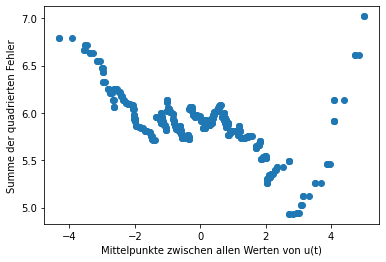

In [5]:
'''
Bestimmung des Splitting points
'''

sortedX = my_data[my_data[:,0].argsort(),:]
#plt.plot(sortedX[:,0])
midpoints = 0.5*(sortedX[:,0]+np.roll(sortedX[:,0],-1))

def abweichung(midpoint):
    childL = sortedX[sortedX[:,0]<=midpoint]
    childR = sortedX[sortedX[:,0]> midpoint]
    s = 0
    for child in [childR, childL]:
        X = child[:,0:2]
        Y = child[:,2]
        A = np.hstack([X, np.ones((len(X),1))])
        a,b,c = np.linalg.lstsq(A, Y, rcond=None)[0]
        y_dach = c+a*X[:,0] + b* X[:,1]
        #y_dach = Y.mean()
        dif = (np.linalg.norm(y_dach - Y))**2
        s += dif
    return s

results = list(map(abweichung, midpoints))
#ix = np.argmin(np.array(results))


plt.scatter(midpoints, results)
plt.ylabel("Summe der quadrierten Fehler")
plt.xlabel("Mittelpunkte zwischen allen Werten von u(t)")
plt.savefig("splittingpoint.pdf")


In [6]:
"""
curvature test for u_0
"""
#1. calculate mean and std
u_0 = X[:,0]
m = u_0.mean()
s = u_0.std()

#2. create four groups and store it in a data frame

df = pd.DataFrame(X)
df.columns = ["u_0","y_0"]
df["sgn"] = sgn
df["interval1"] = df.u_0< m-s*np.sqrt(3)*0.5
df["interval2"] = (m-s*np.sqrt(3)*0.5 <= df.u_0) & (df.u_0< m)
df["interval3"] = (df.u_0>= m) & (m+s*np.sqrt(3)*0.5 > df.u_0)
df["interval4"] = m+s*np.sqrt(3)*0.5 <= df.u_0
df["interval"] = np.zeros(len(df))

df.loc[df['interval1'],'interval'] = 1
df.loc[df['interval2'],'interval'] = 2
df.loc[df['interval3'],'interval'] = 3
df.loc[df['interval4'],'interval'] = 4

df.drop(['interval1', 'interval2', 'interval3', 'interval4'], axis=1, inplace=True)

#3. calculate contingency table
c = df.groupby(['interval','sgn']).count()["u_0"].values

# contingency table with intervals as rows and -,+ as columns
contable = c.reshape((4,2))

p_value_u = chi2_contingency(contable)[1]
contable

array([[ 42,  57],
       [ 20, 112],
       [157,  20],
       [ 45,  45]], dtype=int64)

In [7]:
"""
curvature test for y_0
"""
#1. calculate mean and std
y_0 = X[:,1]
m = y_0.mean()
s = y_0.std()

#2. create four groups and store it in a data frame

df = pd.DataFrame(X)
df.columns = ["u_0","y_0"]
df["sgn"] = sgn
df["interval1"] = df.y_0< m-s*np.sqrt(3)*0.5
df["interval2"] = (m-s*np.sqrt(3)*0.5 <= df.y_0) & (df.y_0< m)
df["interval3"] = (df.y_0>= m) & (m+s*np.sqrt(3)*0.5 > df.y_0)
df["interval4"] = m+s*np.sqrt(3)*0.5 <= df.y_0
df["interval"] = np.zeros(len(df))

df.loc[df['interval1'],'interval'] = 1
df.loc[df['interval2'],'interval'] = 2
df.loc[df['interval3'],'interval'] = 3
df.loc[df['interval4'],'interval'] = 4

df.drop(['interval1', 'interval2', 'interval3', 'interval4'], axis=1, inplace=True)

#3. calculate contingency table
c = df.groupby(['interval','sgn']).count()["u_0"].values

# contingency table with intervals as rows and -,+ as columns
contable = c.reshape((4,2))

p_value_y = chi2_contingency(contable)[1]
contable

array([[58, 73],
       [53, 61],
       [61, 52],
       [92, 48]], dtype=int64)

In [8]:
p_value_y, p_value_u

(0.0017562971503158956, 6.8438186457363485e-37)

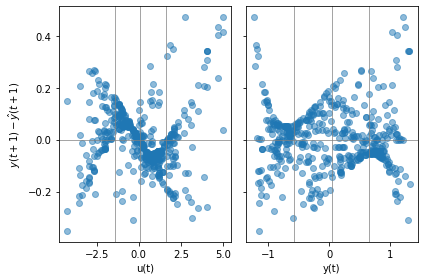

In [9]:
"""
Residuenplot
"""

fig, [ax1, ax2] = plt.subplots(1,2, sharey=True)
ax1.scatter(my_data[:,0], residuals, alpha=0.5)
ax1.set(xlabel='u(t)', ylabel='$y(t+1)-\hat{y}(t+1)$')

m = my_data[:,0].mean()
s = my_data[:,0].std()
ax1.axvline(m-np.sqrt(3)*0.5*s, color='gray', linewidth=0.7)
ax1.axvline(m, color='gray', linewidth=0.7)
ax1.axvline(m+np.sqrt(3)*0.5*s, color='gray', linewidth=0.7)
ax1.axhline(0, color='gray', linewidth=0.7)

ax2.scatter(my_data[:,1], residuals, alpha=0.5)
ax2.set(xlabel='y(t)')

m = my_data[:,1].mean()
s = my_data[:,1].std()
ax2.axvline(m-np.sqrt(3)*0.5*s, color='gray', linewidth=0.7)
ax2.axvline(m, color='gray', linewidth=0.7)
ax2.axvline(m+np.sqrt(3)*0.5*s, color='gray', linewidth=0.7)
ax2.axhline(0, color='gray', linewidth=0.7)

#fig.suptitle("Residuenplot")
fig.tight_layout()
fig.savefig('residual.pdf')

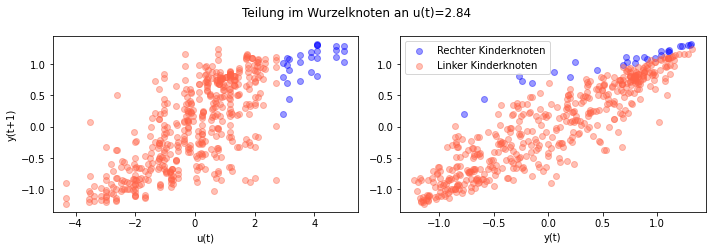

In [10]:
#plt.scatter(u_0,Y, c='green', alpha=0.6)
#plt.scatter(y_0,Y, c='red', alpha=0.3)

all = my_data
childR = all[all[:,0]>2.84]
childL = all[all[:,0]<=2.84]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.5))

ax1.scatter(childR[:,0], childR[:,2], c='blue', alpha=0.4)
ax1.scatter(childL[:,0], childL[:,2], c='tomato', alpha=0.4)
ax1.set(xlabel='u(t)', ylabel='y(t+1)')

ax2.scatter(childR[:,1], childR[:,2], c='blue', alpha=0.4, label="Rechter Kinderknoten")
ax2.scatter(childL[:,1], childL[:,2], c='tomato', alpha=0.4, label="Linker Kinderknoten")
ax2.set(xlabel='y(t)')
ax2.legend()
#handles, labels = ax2.get_legend_handles_labels()
#fig.legend(handles, labels, loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
fig.suptitle("Teilung im Wurzelknoten an u(t)=2.84")
fig.tight_layout()

fig.savefig('splitted_points.pdf')

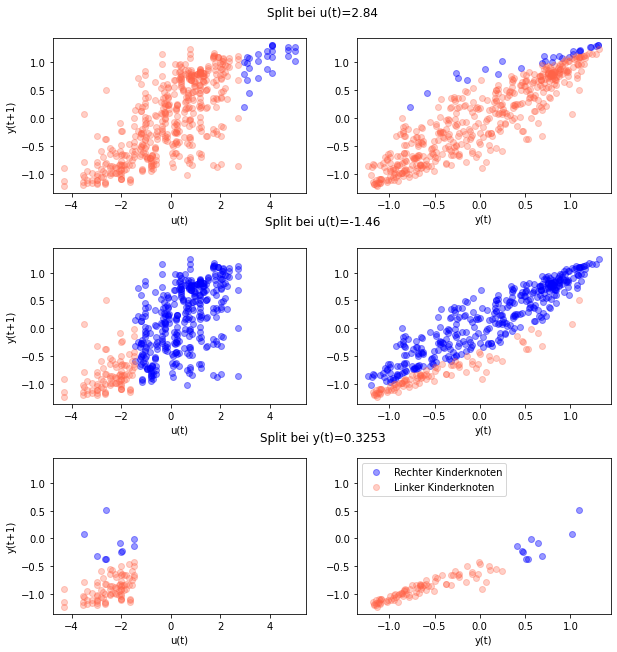

In [11]:
fig, axes = plt.subplots(3,2, figsize=(10,10))

all = my_data
childR = all[all[:,0]>2.84]
childL = all[all[:,0]<=2.84]

axes[0,0].scatter(childR[:,0], childR[:,2], c='blue', alpha=0.4)
axes[0,0].scatter(childL[:,0], childL[:,2], c='tomato', alpha=0.3)
axes[0,0].set(xlabel='u(t)', ylabel='y(t+1)')

axes[0,1].scatter(childR[:,1], childR[:,2], c='blue', alpha=0.4, label="Rechter Kinderknoten")
axes[0,1].scatter(childL[:,1], childL[:,2], c='tomato', alpha=0.3, label="Linker Kinderknoten")
axes[0,1].set(xlabel='y(t)')

childR1 = childL[childL[:,0]>-1.46]
childL1 = childL[childL[:,0]<= -1.46]

axes[1,0].scatter(childR[:,0], childR[:,2], c='white', alpha=0.1)
axes[1,0].scatter(childR1[:,0], childR1[:,2], c='blue', alpha=0.4)
axes[1,0].scatter(childL1[:,0], childL1[:,2], c='tomato', alpha=0.3)
axes[1,0].set(xlabel='u(t)', ylabel='y(t+1)')

axes[1,1].scatter(childR[:,1], childR[:,2], c='white', alpha=0.1, label="Rechter Kinderknoten")
axes[1,1].scatter(childR1[:,1], childR1[:,2], c='blue', alpha=0.4)
axes[1,1].scatter(childL1[:,1], childL1[:,2], c='tomato', alpha=0.3)
axes[1,1].set(xlabel='y(t)')

childR2 = childL1[childL1[:,1] > 0.3253]
childL2 = childL1[childL1[:,1] <= 0.3253]

axes[2,0].scatter(childR[:,0], childR[:,2], c='white', alpha=0.1)
axes[2,0].scatter(childR1[:,0], childR1[:,2], c='white', alpha=0.1)
axes[2,0].scatter(childR2[:,0], childR2[:,2], c='blue', alpha=0.4)
axes[2,0].scatter(childL2[:,0], childL2[:,2], c='tomato', alpha=0.3)
axes[2,0].set(xlabel='u(t)', ylabel='y(t+1)')

axes[2,1].scatter(childR[:,1], childR[:,2], c='white', alpha=0.1)
axes[2,1].scatter(childR1[:,1], childR1[:,2], c='white', alpha=0.1)
axes[2,1].scatter(childR2[:,1], childR2[:,2], c='blue', alpha=0.4, label="Rechter Kinderknoten")
axes[2,1].scatter(childL2[:,1], childL2[:,2], c='tomato', alpha=0.3, label="Linker Kinderknoten")
axes[2,1].set(xlabel='y(t)')
axes[2,1].legend(loc='upper left')

fig.tight_layout()

fig.text(0.5, 0.93, 'Split bei u(t)=2.84', ha='center', fontsize=12)
fig.text(0.5, 0.64, 'Split bei u(t)=-1.46', ha='center', fontsize=12)
fig.text(0.5, 0.34, 'Split bei y(t)=0.3253', ha='center', fontsize=12)
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)
fig.savefig('whole_branch.pdf')

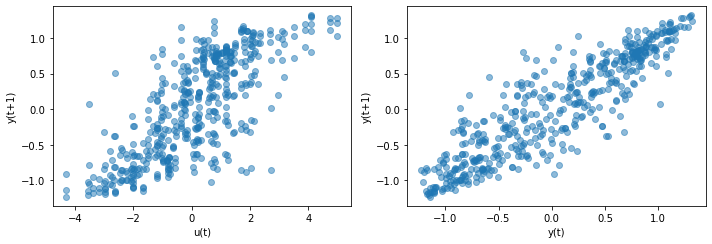

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3.5))

ax1.scatter(my_data[:,0], my_data[:,2], alpha=0.5)
ax1.set(xlabel='u(t)', ylabel='y(t+1)')
ax2.scatter(my_data[:,1], my_data[:,2], alpha = 0.5)
#ax2.set(xlabel='y_0', ylabel='y_1')
ax2.set_xlabel("y(t)")
ax2.set_ylabel("y(t+1)")

fig.tight_layout()

fig.savefig('pointsinnode.pdf')

In [13]:
children2 = all[all[:,0]<=-1.46]

"""
curvature test for y_0
"""
#1. calculate mean and std
y_0 = children2[:,1]
m = y_0.mean()
s = y_0.std()

#2. create four groups and store it in a data frame

df = pd.DataFrame(X)
df.columns = ["u_0","y_0"]
df["sgn"] = sgn
df["interval1"] = df.y_0< m-s*np.sqrt(3)*0.5
df["interval2"] = (m-s*np.sqrt(3)*0.5 <= df.y_0) & (df.y_0< m)
df["interval3"] = (df.y_0>= m) & (m+s*np.sqrt(3)*0.5 > df.y_0)
df["interval4"] = m+s*np.sqrt(3)*0.5 <= df.y_0
df["interval"] = np.zeros(len(df))

df.loc[df['interval1'],'interval'] = 1
df.loc[df['interval2'],'interval'] = 2
df.loc[df['interval3'],'interval'] = 3
df.loc[df['interval4'],'interval'] = 4

df.drop(['interval1', 'interval2', 'interval3', 'interval4'], axis=1, inplace=True)

#3. calculate contingency table
c = df.groupby(['interval','sgn']).count()["u_0"].values

# contingency table with intervals as rows and -,+ as columns
contable = c.reshape((4,2))

p_value_y = chi2_contingency(contable)[1]

"""
curvature test for u_0
"""
#1. calculate mean and std
u_0 = children2[:,0]
m = u_0.mean()
s = u_0.std()

#2. create four groups and store it in a data frame

df = pd.DataFrame(X)
df.columns = ["u_0","y_0"]
df["sgn"] = sgn
df["interval1"] = df.u_0< m-s*np.sqrt(3)*0.5
df["interval2"] = (m-s*np.sqrt(3)*0.5 <= df.u_0) & (df.u_0< m)
df["interval3"] = (df.u_0>= m) & (m+s*np.sqrt(3)*0.5 > df.u_0)
df["interval4"] = m+s*np.sqrt(3)*0.5 <= df.u_0
df["interval"] = np.zeros(len(df))

df.loc[df['interval1'],'interval'] = 1
df.loc[df['interval2'],'interval'] = 2
df.loc[df['interval3'],'interval'] = 3
df.loc[df['interval4'],'interval'] = 4

df.drop(['interval1', 'interval2', 'interval3', 'interval4'], axis=1, inplace=True)

#3. calculate contingency table
c = df.groupby(['interval','sgn']).count()["u_0"].values

# contingency table with intervals as rows and -,+ as columns
contable = c.reshape((4,2))

p_value_u = chi2_contingency(contable)[1]


In [14]:
p_value_u,p_value_y

(0.07164917347950395, 0.015017479477452961)

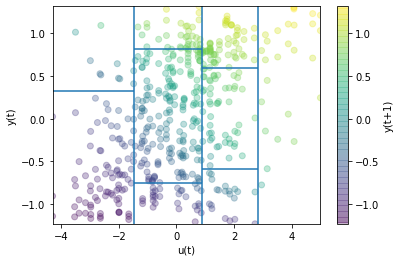

In [15]:
"""
Partitionsplot
"""
data = pd.read_csv("train_data.csv", sep=",")
points = data.iloc[:,1:3]
mypoints = points.to_numpy()
xminimum = mypoints[:,0].min()
xmaximum = mypoints[:,0].max()
yminimum = mypoints[:,1].min()
ymaximum = mypoints[:,1].max()
values = data.iloc[:,3].to_numpy()

# Syntax: plt.axis([xmin, xmax, ymin, ymax])
plt.axis([xminimum, xmaximum, yminimum, ymaximum])
plt.scatter(mypoints[:,0], mypoints[:,1], c=values, alpha=0.3)
#parallel zur y-Achse, Split an u_0
plt.vlines(x=2.84, ymin=yminimum, ymax=ymaximum)
#plt.vlines(x=3.33, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=-1.46, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=0.8858, ymin=yminimum, ymax=ymaximum)
#plt.vlines(x=-2.06, ymin=yminimum, ymax=0.3253)
#plt.vlines(x=-2.99, ymin=yminimum, ymax=0.3253)
#plt.vlines(x=-0.6305, ymin=-0.7542, ymax=0.5294)
#plt.vlines(x=1.42, ymin=-0.5923, ymax=0.5929)

#parallel zur x-Achse, Split an y_0
plt.hlines(y=0.3253, xmin=xminimum, xmax=-1.46)
plt.hlines(y=0.8115, xmin=-1.46, xmax=0.8858)
plt.hlines(y=-0.7542, xmin=-1.46, xmax=0.8858)
#plt.hlines(y=0.5294, xmin=-1.46, xmax=0.8858)
plt.hlines(y=-0.5923, xmin=0.8858, xmax=2.84)
#plt.hlines(y=-0.9631, xmin=0.8858, xmax=2.84)
plt.hlines(y=0.5929, xmin=0.8858, xmax=2.84)

plt.xlabel("u(t)")
plt.ylabel("y(t)")
cbar = plt.colorbar()
cbar.set_label('y(t+1)')
plt.savefig('partition2d_slm.pdf')

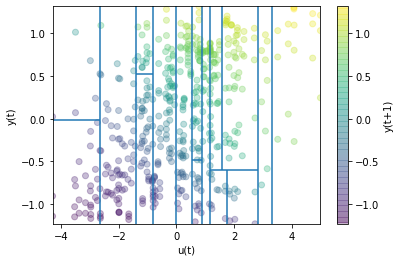

In [17]:
"""
Partitionsplot für simple linear model
"""
data = pd.read_csv("train_data.csv", sep=",")
points = data.iloc[:,1:3]
mypoints = points.to_numpy()
xminimum = mypoints[:,0].min()
xmaximum = mypoints[:,0].max()
yminimum = mypoints[:,1].min()
ymaximum = mypoints[:,1].max()
values = data.iloc[:,3].to_numpy()

# Syntax: plt.axis([xmin, xmax, ymin, ymax])
plt.axis([xminimum, xmaximum, yminimum, ymaximum])
plt.scatter(mypoints[:,0], mypoints[:,1], c=values, alpha=0.3)
#parallel zur y-Achse, Split an u_0
plt.vlines(x=-0.0134, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=-1.39, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=-2.65, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=-0.8184, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=1.17, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=0.5252, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=0.8858, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=2.84, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=3.33, ymin=yminimum, ymax=ymaximum)
plt.vlines(x=1.76, ymin=yminimum, ymax=-0.5985)
plt.vlines(x=1.59, ymin=-0.5985, ymax=ymaximum)

#parallel zur x-Achse, Split an y_0
plt.hlines(y=-0.5985, xmin=1.17, xmax=2.84)
plt.hlines(y=-0.4836, xmin=0.5252, xmax=0.8858)
plt.hlines(y=0.5227, xmin=-1.39, xmax=-0.8184)
plt.hlines(y=-0.00944, xmin=xminimum, xmax=-2.65)

plt.xlabel("u(t)")
plt.ylabel("y(t)")
cbar = plt.colorbar()
cbar.set_label('y(t+1)')
plt.savefig('partition2d_slm.pdf')

<ipython-input-37-f5e4022ce766>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(u, y, z, cmap='coolwarm', vmin=z_min, vmax=z_max)


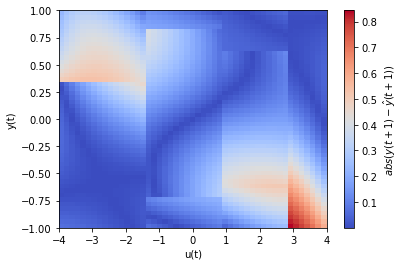

In [37]:
"""
Residuen-Heatmap
"""
u_0 = np.linspace(-4,4,50)
y_0 = np.linspace(-1,1,50)
pred = data = pd.read_csv("predictions.csv", header=None, sep=" ")
pred = pred.values
endings = pred[:,-1]
endings = np.hstack((endings,endings))
new1 = np.hstack((pred[0,:],endings))
new = new1.reshape((50,50))
U,Y = np.meshgrid(u_0,y_0)
y_tplus1 = np.arctan(0.3*U + 0.7*np.tan(Y))
values = np.abs(new-y_tplus1)

# generate 2 2d grids for the x & y bounds
y, u = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-4, 4, 50))
z = values

z_min, z_max = z.min(), z.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(u, y, z, cmap='coolwarm', vmin=z_min, vmax=z_max)
#ax.set_title('Colormap der Residuen')
# set the limits of the plot to the limits of the data
ax.axis([u.min(), u.max(), y.min(), y.max()])
ax.set_xlabel("u(t)")
ax.set_ylabel("y(t)")
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('$abs(y(t+1)-\hat{y}(t+1))$')
fig.savefig('residualheatmap.pdf')

<ipython-input-38-986339cf2e27>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axes[0].pcolormesh(u, y, z, cmap='coolwarm', vmin=z_min, vmax=z_max)
<ipython-input-38-986339cf2e27>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axes[1].pcolormesh(u, y, z, cmap='coolwarm', vmin=z_min, vmax=z_max)


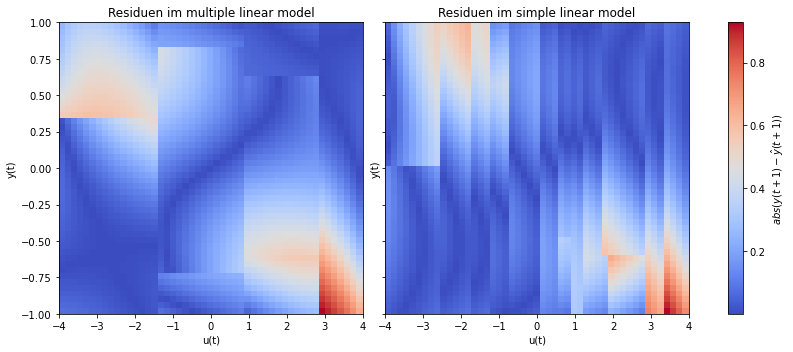

In [38]:
"""
Residuen-Heatmap
"""
u_0 = np.linspace(-4,4,50)
y_0 = np.linspace(-1,1,50)
pred = data = pd.read_csv("predictions.csv", header=None, sep=" ")
pred = pred.values
endings = pred[:,-1]
endings = np.hstack((endings,endings))
new1 = np.hstack((pred[0,:],endings))
new = new1.reshape((50,50))
U,Y = np.meshgrid(u_0,y_0)
y_tplus1 = np.arctan(0.3*U + 0.7*np.tan(Y))
values = np.abs(new-y_tplus1)

# generate 2 2d grids for the x & y bounds
y, u = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-4, 4, 50))
z = values

z_min, z_max = z.min(), z.max()

fig, axes = plt.subplots(1,2, figsize = (12,5), sharey=True)

c = axes[0].pcolormesh(u, y, z, cmap='coolwarm', vmin=z_min, vmax=z_max)
axes[0].set_title('Residuen im multiple linear model')
# set the limits of the plot to the limits of the data
axes[0].axis([u.min(), u.max(), y.min(), y.max()])
axes[0].set_xlabel("u(t)")
axes[0].set_ylabel("y(t)")


u_0 = np.linspace(-4,4,50)
y_0 = np.linspace(-1,1,50)
pred = data = pd.read_csv("predictions_s.csv", header=None, sep=" ")
pred = pred.values
endings = pred[:,-1]
endings = np.hstack((endings,endings))
new1 = np.hstack((pred[0,:],endings))
new = new1.reshape((50,50))
U,Y = np.meshgrid(u_0,y_0)
y_tplus1 = np.arctan(0.3*U + 0.7*np.tan(Y))
values = np.abs(new-y_tplus1)

# generate 2 2d grids for the x & y bounds
y, u = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-4, 4, 50))
z = values

z_min, z_max = z.min(), z.max()



c = axes[1].pcolormesh(u, y, z, cmap='coolwarm', vmin=z_min, vmax=z_max)
axes[1].set_title('Residuen im simple linear model')
# set the limits of the plot to the limits of the data
axes[1].axis([u.min(), u.max(), y.min(), y.max()])
axes[1].set_xlabel("u(t)")
axes[1].set_ylabel("y(t)")

#fig.savefig('residualheatmap_slm.pdf')
fig.tight_layout()
cbar = fig.colorbar(c, ax=axes.ravel().tolist())
cbar.set_label('$abs(y(t+1)-\hat{y}(t+1))$')
fig.savefig('residualheatmap_compare.pdf')